==============================================================================================
## Practicum 6: Dace detection by Viola-Jones 
==============================================================================================



The exercises of this notebook will show how we can perform face detectionusing:

- Haar features
- Integral images
- Adaboost classifier

#### Problem we want to solve
- Given a set of training images of faces and no faces, a new image, we would like to detect if there is a subregion of the image with a face.

In [1]:
import numpy as np
import os
import matplotlib
from PIL import Image
from multiprocessing.dummy import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt
from skimage import io
from skimage.exposure import rescale_intensity

%matplotlib inline

## Haar like features applied for face detection

Today's exercices will practise the following:

- Integral images and a classical use for fast harr like feature computation.
- Haar like features for images.
- Use of Adaboost for classification.
- Decisions based on a user defined threshold for balancing precision and recall.

**1) Build a function `to_integral_image` that computes the integral image of an input (2D) array.**

The integral image will have an additional row and column full of zeros.
Convince yourself that the values of the integral image are correct.

```python
 def to_integral_image(img_arr):
    row_sum = np.zeros(img_arr.shape)
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    # Add here code
    
    return integral_image_arr
```


You can make following tests:
 
 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`
 
Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```




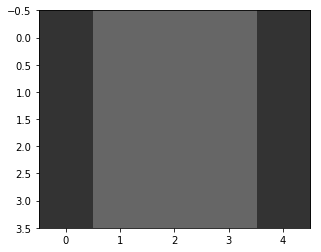

In [2]:
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
img_array.shape
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
plt.show()

In [3]:
from skimage.transform import integral_image

def to_integral_image(img_arr):
   
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for a given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    #row_sum = np.zeros(img_arr.shape)
    
    #We need to add one more row of zeros at the top of the matrix and one more column and the start of the matrix
    #because if the rectangle we want the compute is as big as the image, we will have an index (-1) error
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1)) #Extend the dimensions
    integral = integral_image(img_arr) #Convert the image to integral
    integral_image_arr[1:,1:] = integral #Put the integral image to the already-made matrix
    return integral_image_arr

** 2) Build a function to compute the  sum of the pixel intensities within a  rectangle using the integral image. The rectangle will be defined using the top left and bottom right coordinates.**

Make the function with the following header:
```
def sum_region(integral_img_arr, top_left, bottom_right):
```


In [4]:
def sum_region(integral_img_arr, top_left, bottom_right):
    
    #Just compute the susbstractions
    A = integral_img_arr[bottom_right[0], 
                         bottom_right[1]] - integral_img_arr[bottom_right[0], 
                         top_left[1]]- (integral_img_arr[top_left[0], 
                         bottom_right[1]] - integral_img_arr[top_left[0],
                         top_left[1]])
    return A

In [5]:
# result you should get (12)
sum_region(to_integral_image(img_array), [1,1],[3,4])

12.0

In [6]:
# result you should get (32)
sum_region(to_integral_image(img_array), [0,0],[-1,-1])

32.0

**3) Compute the integral image for all the following images:**
    
- training images of faces: save results in **`faces_ii_training`**
- testing images of face: save the results in **`faces_ii_testing`**
- training images of non faces: **`non_faces_ii_training`**
- testing images of non faces:  **`non_faces_ii_testing`**

To do so build a function to read all the images inside a given folder:

```python
def load_images(path):
    images = []
    for _file in os.listdir(path):
        if _file.endswith('.png'):
           #### Read image
           #### Remember to scale the image (wih the max pixel intensity value)
     
    return images
 ```

In [7]:
pos_training_path = 'trainingdata/faces'
neg_training_path = 'trainingdata/nonfaces'
pos_testing_path = 'trainingdata/faces/test'
neg_testing_path = 'trainingdata/nonfaces/test'

In [8]:
def load_images(path):
    images = []
    ## fill in
    for _file in os.listdir(path): #For every file,
        if _file.endswith('.png'): #if its an image,
            image=io.imread(path+"/"+_file) #Read it
            #After rescale his intensity, convert it to integral and append
            images.append(to_integral_image(rescale_intensity(image,out_range = (0,image.max()))))
    return images

In [9]:
#Compute every list of images
faces_ii_training = load_images(pos_training_path)
faces_ii_testing = load_images(pos_testing_path)
non_faces_ii_training=load_images(neg_training_path)
non_faces_ii_testing=load_images(neg_testing_path)

C:\Users\blair\Anaconda3\lib\site-packages\skimage\exposure\exposure.py:297: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)


**4) Compute the Haar features of an image**

The code given will use the  `sum_region` function you have implemented to compute Haar like features.
The following code, for example, will compute a vertical Haar like feature
```python
    first = sum_region(int_img, 
                      self.top_left, 
                      (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
    second = sum_region(int_img, 
                       (self.top_left[0], int(self.top_left[1] + self.height / 2)),
                       self.bottom_right)
    score = first - second
```

We provide you with `HaarLikeFeature` class that has build in a `get_score` function and a `get_vote` function.

Your job is to 
```python
def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.
                
                
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features
```

In [10]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: violajonse.HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)


In [11]:

def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    :return: List of selected features
    :rtype: list[violajones.HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1))

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=None)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')


    return classifiers

def _get_feature_vote(feature, image):
    return feature.get_vote(image)

def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                #Positive
                haar = HaarLikeFeature(feature, (feature_start_width, feature_start_height), feature_width, feature_height, 0, 1)
                #Negative
                haarN = HaarLikeFeature(feature, (feature_start_width, feature_start_height), feature_width, feature_height, 0, -1)
                # - append the HaarlikeFeatures in the features list.
                features.append(haar)
                features.append(haarN)
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.
                
            
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features


** 5)Use the learn method  to learn a list of classifiers with the train data **

With the `learn` function you can build a list of classifiers that detect whether an image contains a face or not.

Use the following hyperparameters of the features and `num_classifiers`.

In [12]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [13]:
%%time 
#Just call learn with the correct parametres.
#We decided to choose testing because our next results are similar with your output
classifiers = learn(faces_ii_testing,non_faces_ii_testing, num_classifiers, min_feature_width,max_feature_width,min_feature_height,max_feature_height)
#print(len(classifiers))

Creating Haar-like features..
	18 features created.
	Time needed for calculating Harr-like features: 0.0
Calculating scores for images..
	Time needed for calculating scores: 0.5003340244293213
Selecting classifiers..
	Time needed for Selecting Classifiers: 0.017511606216430664 

Wall time: 519 ms


** 6) Make a function for voting with different classifiers **

Build two functions `ensemble_vote` and `ensemble_vote_all`.

- `ensemble_vote(int_img, classifiers)` has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise

- `ensemble_vote_all(int_imgs, classifiers)` has to loop over the list `int_imgs` and compute the `ensemble_vote` for each image in the list. It has to return a list containing all the votes for all the images in  `int_imgs`.

Use the functions to compute the train and test acurracies for faces and non faces.

Print the results in the following format:
```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

It is not required to get exactly these results but print the information in this format. It facilitates understanding the results.

In [14]:
def ensemble_vote(int_img, classifiers):
    #Counts for positive & negative values
    countPos = 0
    countNeg = 0
    puntuacions = [] #List of scores
    for i in classifiers: #For every classifier
        puntuacions.append(_get_feature_vote(i, int_img)) #Append the feature vote
    #Now count if there is more positive values than negative
    #Return 0 if there are more negative scores (its not a face), 1 if not (its a face)
    for i in puntuacions:
        if i >= 0:
            countPos+=1
        else:
            countNeg+=1
    if countPos > countNeg:
        return 1
    else:
        return 0

In [15]:
#Now do it for every image on a list
def ensemble_vote_all(int_imgs, classifiers):
    votes= []
    for i in int_imgs:
        votes.append(ensemble_vote(i,classifiers))
    return votes


In [16]:
#Lengths for every list of images
lenTrain = len(faces_ii_training)
lenTest = len(faces_ii_testing)
lenTrainN = len(non_faces_ii_training)
lenTestN = len(non_faces_ii_testing)

#Scores for every list of images
votesTrainPos = ensemble_vote_all(faces_ii_training,classifiers)
votesTestPos = ensemble_vote_all(faces_ii_testing,classifiers)
votesTrainN = ensemble_vote_all(non_faces_ii_training,classifiers)
votesTestN = ensemble_vote_all(non_faces_ii_testing,classifiers)

#Counts for every list of images
countPosTrain = votesTrainPos.count(1)
countNegTrain = votesTrainN.count(0)
countPosTest = votesTestPos.count(1)
countNegTest = votesTestN.count(0)

print("Train results:\n")
print("Correctly identified Faces: ",countPosTrain,"/",lenTrain,"(",float(countPosTrain)/lenTrain*100,"%)","\n")
print("Correctly identified non-Faces: ",countNegTrain,"/",lenTrainN,"(",float(countNegTrain)/lenTrainN*100,"%)","\n")

print("Test results: \n")
print("Correctly identified Faces: ",countPosTest,"/",lenTest,"(",float(countPosTest)/lenTest*100,"%)","\n")
print("Correctly identified non-Faces: ",countNegTest,"/",lenTestN,"(",float(countNegTest)/lenTestN*100,"%)","\n")

Train results:

Correctly identified Faces:  1382 / 2429 ( 56.895841910251136 %) 

Correctly identified non-Faces:  4196 / 8548 ( 49.08750584932148 %) 

Test results: 

Correctly identified Faces:  278 / 472 ( 58.89830508474576 %) 

Correctly identified non-Faces:  66 / 128 ( 51.5625 %) 



** 7) Make another test with 20 classifiers instead of 2**

Inspect the classification results if you use adaboost with 20 classifiers. Use the same hyperameters for the features.
Print the results as in the previous exercise:

```
train results:
Correctly identified Faces: 2256/2429  (92.87772745986003%)
Correctly identified non-Faces: 7046/8548  (82.42863827795975%)

test results:
Correctly identified Faces: 285/472  (60.381355932203384%)
Correctly identified non-Faces: 104/128  (81.25%)
```

- Do the classification results improved in the train data?



In [17]:
#MY AND MY PARTNER PC DIDNT COMPUTE CORRECTLY THE LEARN FUNCTION FOR 20 FILTERS
#THE MAXIMUM WE GOT WAS 18
num_classifiers = 18
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [18]:
%%time 
classifiers = learn(faces_ii_training,non_faces_ii_training, num_classifiers, min_feature_width,max_feature_width,min_feature_height,max_feature_height)
#print(len(classifiers))

Creating Haar-like features..
	18 features created.
	Time needed for calculating Harr-like features: 0.0
Calculating scores for images..
	Time needed for calculating scores: 9.088577508926392
Selecting classifiers..
	Time needed for Selecting Classifiers: 1.8612442016601562 

Wall time: 11 s


In [19]:
#Lengths for every list of images
lenTrain = len(faces_ii_training)
lenTest = len(faces_ii_testing)
lenTrainN = len(non_faces_ii_training)
lenTestN = len(non_faces_ii_testing)

#Scores for every list of images
votesTrainPos = ensemble_vote_all(faces_ii_training,classifiers)
votesTestPos = ensemble_vote_all(faces_ii_testing,classifiers)
votesTrainN = ensemble_vote_all(non_faces_ii_training,classifiers)
votesTestN = ensemble_vote_all(non_faces_ii_testing,classifiers)

#Counts for every list of images
countPosTrain = votesTrainPos.count(1)
countNegTrain = votesTrainN.count(0)
countPosTest = votesTestPos.count(1)
countNegTest = votesTestN.count(0)

print("Train results:\n")
print("Correctly identified Faces: ",countPosTrain,"/",lenTrain,"(",float(countPosTrain)/lenTrain*100,"%)","\n")
print("Correctly identified non-Faces: ",countNegTrain,"/",lenTrainN,"(",float(countNegTrain)/lenTrainN*100,"%)","\n")

print("Test results: \n")
print("Correctly identified Faces: ",countPosTest,"/",lenTest,"(",float(countPosTest)/lenTest*100,"%)","\n")
print("Correctly identified non-Faces: ",countNegTest,"/",lenTestN,"(",float(countNegTest)/lenTestN*100,"%)","\n")

Train results:

Correctly identified Faces:  1395 / 2429 ( 57.43104158089749 %) 

Correctly identified non-Faces:  5580 / 8548 ( 65.27842770238652 %) 

Test results: 

Correctly identified Faces:  276 / 472 ( 58.47457627118644 %) 

Correctly identified non-Faces:  70 / 128 ( 54.6875 %) 



**Do the classification results improved in the train data?**

* Yeah it did. Let's compare:

* * With Train data and 2 classifiers, we got 1382 detected faces, a 56%. Now, we got 1395, only 1% more. With non-faces, we detected 5580, a 65% vs. the 49% that we got with 2 classifiers.

* * With Test data and 2 classifiers, we found 278 faces. Now we've got 276. This value is the only one that didn't increase. However, with 2 classifiers we found 66 non-faces, and now we've got 70, an increase of a 3%.


** 8) Change the voting functions so that you can set a threshold for deciding a prediction**

Create the following functions

- `ensemble_vote_t`: returns the final decision of a list of classifiers for a given threshold.
- `ensemble_vote_all_t`: Iterates over a list of integral images and returns the  final decision of a list of classifiers for each of the images (for a given threshold).



compute the following:

- a) number of correct faces over all faces (in the train data)
- b) number of correct non faces over all non faces (in the train data)
- c) number of correct faces over all faces (in the test data)
- d) number of correct non faces over all non faces (in the test data)

Using the list of 20 classifiers.


The quantities have to be computed for each of the following thresholds:

```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

- Make a bar plot for a), b), c) and d). In the x axis write the threshold value. 

- What happens when you increase the threshold value?

In [20]:
thresholds = np.array([x for x in range(-5,5,1)])/10.
print(thresholds)

[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]


In [21]:
#(We don't use them)
correct_faces_train_t = []
correct_non_faces_train_t = []
correct_faces_test_t = []
correct_non_faces_test_t = []

In [22]:
def ensemble_score(int_img, classifiers):
    return sum([c.get_vote(int_img) for c in classifiers])

def ensemble_vote_t(int_img, classifiers,t):
    
    puntuacio = ensemble_score(int_img,classifiers) #Get the score
    if (puntuacio > t): #Find out if it's bigger than the treshold
        return 1 
    return 0
        
def ensemble_vote_all_t(int_imgs, classifiers,t=-0.1): #Do it for all images in the list
    votes= []
    for i in int_imgs:
        votes.append(ensemble_vote_t(i,classifiers,t))
    return votes

In [23]:
#This function computes the counts of faces or non faces
#polarity: couunt zeros or ones
#t = threshold
def count(llista,polarity,t):
    votes = ensemble_vote_all_t(llista,classifiers,t)
    count = votes.count(polarity)
    
    return count

In [24]:
#This function gets the scores for every threshold
def results(llista,polarity,t):
    counts = []
    for i in t:
        counts.append(count(llista,polarity,i))
    return counts

a) number of correct faces over all faces (in the train data):



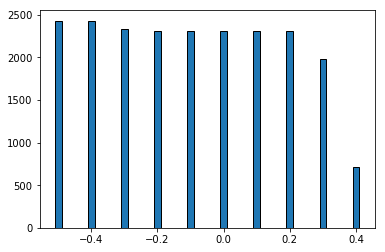

In [25]:
#Results & its plots
print("a) number of correct faces over all faces (in the train data):\n")
plt.bar(thresholds,results(faces_ii_training,1,thresholds),edgecolor="black",width=0.02)
plt.show()

b) number of correct non faces over all non faces (in the train data):



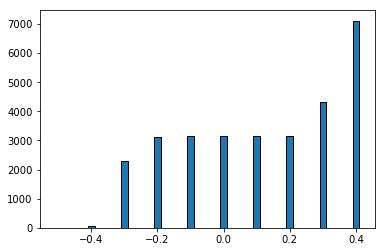

In [26]:
print("b) number of correct non faces over all non faces (in the train data):\n")
plt.bar(thresholds,results(non_faces_ii_training,0,thresholds),edgecolor="black",width=0.02)
plt.show()

c) number of correct faces over all faces (in the test data):



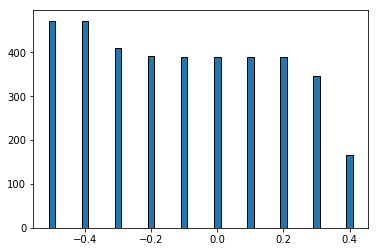

In [27]:
print("c) number of correct faces over all faces (in the test data):\n")
plt.bar(thresholds,results(faces_ii_testing,1,thresholds),edgecolor="black",width=0.02)
plt.show()

d) number of correct non faces over all non faces (in the test data):



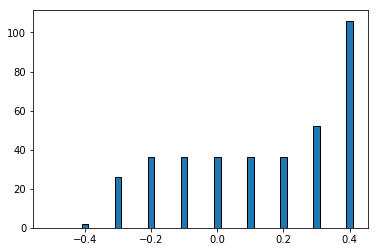

In [28]:
print("d) number of correct non faces over all non faces (in the test data):\n")
plt.bar(thresholds,results(non_faces_ii_testing,0,thresholds),edgecolor="black",width=0.02)
plt.show()

**Comment extensively the code and the results.**

6) Make a function for voting with different classifiers
* In this exercice we decided to train our classifiers with the faces of the test, not the train. Once trained, we got similars results in comparision with the already-made output. There's only one value, the "Correctly identified Faces" in the Train images, because we got 1382 and in the output was 2129. The rest of the values are more or less similar.

7) Make another test with 20 classifiers instead of 2
* With 18 classifiers we got closer to the already-made output only with the Test images. With train images, our values are lower: 
* 1395/2429 of faces and 5580/8548 of non-faces besides the 2256/2429 of faces and 7046/8548 non-faces. In any case, our values with 18 classifiers are higher than with 2. We trained our classifiers with training images.

8) Change the voting functions so that you can set a threshold for deciding a prediction
* We assume our plots are correct because (with Test and Train faces):
* * If we increase the threshold, we progressively get less detected faces.
* * If we increase the threshold, we progressively get more non-faces

With the implementation of a threshold, we can find an optimal value that leads us to get the maximum number of correct faces (or the maximum number of correct non-faces) with our trained classifiers. Those plots help us to see wich value we should take. For example, in the first plot, we can see that the number of finded faces doesn't change very much between -0.2 and 0.2, so I will take a threshold around this values. 

## Face recognition by eigenfaces (Optional)

Explore the library for the face recognition in sci-kit learn: http://scikit-learn.org/0.18/auto_examples/applications/face_recognition.html. 

** Observe and comment how the results and time change when you use different number of PCA components: e.g. 11, 50, 100, 150.**

Note: in order to observe the results of the recognition, the following measures are used:
- precision: P=TP/(TP+FP)
- recall: R=TP/(TP+FN)
- F1-score: 2*P*R/(P+R)
where TP means True Positives (that is how much faces are correctly recognized),
FP means False Positives (how much faces are considered by the classifier as belonging to a class wrongly)
FN means False Negatives (how many training data from a class are missed by the classifier) and
TN means True Negatives (how many training data not belonging to a class are classified correctly).

For more details, you can look at: https://en.wikipedia.org/wiki/Precision_and_recall.

Note: In the library a classifier called Support Vector Machines (SVM) is used that similarly to knn and Adaboost learns to classify objects (faces, in this case). It is not necessary to get familiar (going into details) about this classifier. The important thing to know is that the following lines train the classifier model:

*clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)* # inicializes the model
*clf = clf.fit(X_train_pca, y_train)* # trains the model on the training data given by X_train_pca with labels y_train (the names of the persons)

and the classification of the test data is given by:

*y_pred = clf.predict(X_test_pca)*  # classifies the test data

where y_pred contains the predicted labels of the data in the test data given by X_test_pca.


**Delivery deadline:** 5 of January, 2018, 11:50 p.m.